# 전력사용량 예측

- target : 일별 전력사용량
- 심사 기준: SMAPE(Symmetric Mean Absolute Percentage Error)
 - Public Score: 2022.08.25~2022.08.27의 실제 전력사용량 데이터로 측정
 - Private Score: 2022.08.25~2022.08.31의 실제 전력사용량 데이터로 측정

- 데이터
 - train : 100개 건물별 2040개 데이터 (총 204000행) / 2022.06.01 00시 ~ 2022.08.24일 23시 (총 24시간, 85일)
 - bulding : 100개 건물별 유형 및 정보 (총 100행)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = '/content/drive/MyDrive/데이콘 캐글 컴페티션/DACON_23.07_PowerConsumption/'
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
building = pd.read_csv(f"{DATA_PATH}building_info.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

# 데이터 확인 / EDA

https://dacon.io/competitions/official/236125/codeshare/8500?page=1&dtype=recent

### train

In [ ]:
train # target : 전력소비량

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


In [ ]:
test #일조, 일사, 전력소비량 빠짐

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [ ]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [ ]:
#데이터센터

In [ ]:
# mask = (train['건물번호'] == 1)
# train[mask].shape, train.shape  # ((2040, 10), (204000, 10))

In [ ]:
train_ft = pd.merge(train,building,on='건물번호',how='left')
train_ft

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,건물기타,110634.00,39570.00,-,-,-
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,건물기타,110634.00,39570.00,-,-,-
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,건물기타,110634.00,39570.00,-,-,-
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,건물기타,110634.00,39570.00,-,-,-
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,건물기타,110634.00,39570.00,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04,호텔및리조트,57497.84,40035.23,-,-,-
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96,호텔및리조트,57497.84,40035.23,-,-,-
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12,호텔및리조트,57497.84,40035.23,-,-,-
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08,호텔및리조트,57497.84,40035.23,-,-,-


### building
- 연전력소비 : 빌딩 데이터에, 총 전력사용량 칼럼을 추가해서 상관관계 확인하기

In [ ]:
def get_total_kwh(building_num) :
    mask = (train['건물번호'] == building_num)
    df = pd.DataFrame(train[mask])
    return df['전력소비량(kWh)'].sum()

get_total_kwh(1)

5412163.68

In [ ]:
#연전력소비 추가
building_ft = building.copy()

building_ft['연전력소비(kWh)'] = 0

for i in range(100):
    building_ft.loc[i, '연전력소비(kWh)'] = get_total_kwh(i+1)


In [ ]:
building_ft

#태양광 용량
#ESS 저장 용량
#PCS 용량

#건물기타~데이터센터 / 4개 / 4개
#1~36, 37~68, 69~100 -> 데이터 센터 ->


,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),연전력소비(kWh)
0,1,건물기타,110634.00,39570.00,-,-,-,5412163.68
1,2,건물기타,122233.47,99000.00,-,-,-,3421114.02
2,3,건물기타,171243.00,113950.00,40,-,-,2945920.14
3,4,건물기타,74312.98,34419.62,60,-,-,2030669.01
4,5,건물기타,205884.00,150000.00,-,2557,1000,5587661.16
...,...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-,5728397.70
96,97,호텔및리조트,55144.67,25880.00,-,-,-,2521281.24
97,98,호텔및리조트,53578.62,17373.75,-,-,-,2317674.42
98,99,호텔및리조트,53499.00,40636.00,-,-,-,2366164.98


In [ ]:
train['전력소비량(kWh)'].sum()

500011438.23833305

In [ ]:
building_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
 7   연전력소비(kWh)    100 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 6.4+ KB


In [ ]:
# building 데이터프레임에서 "건물유형" 칼럼에 대해 One-Hot Encoding
building_ft = pd.get_dummies(building_ft, columns=['건물유형'])

In [ ]:

# 상관계수 계산
correlation_matrix = building_ft.corr()

# '연전력소비량' 칼럼과 다른 변수들과의 상관계수만 추출
correlation_with_power_consumption = correlation_matrix['연전력소비(kWh)']

# 결과 출력
print(correlation_with_power_consumption)

건물번호           -0.195814
연면적(m2)         0.014607
냉방면적(m2)        0.017842
연전력소비(kWh)      1.000000
건물유형_건물기타      -0.089512
건물유형_공공        -0.100555
건물유형_대학교        0.394272
건물유형_데이터센터      0.300442
건물유형_백화점및아울렛   -0.024536
건물유형_병원         0.060532
건물유형_상용        -0.019882
건물유형_아파트       -0.149712
건물유형_연구소        0.046895
건물유형_지식산업센터    -0.067577
건물유형_할인마트      -0.135700
건물유형_호텔및리조트    -0.127286
Name: 연전력소비(kWh), dtype: float64


<ipython-input-20-773bc1e8d4f5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = building_ft.corr()


In [ ]:
building_ft.corr()

<ipython-input-21-ff9d4bc523e7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  building_ft.corr()


,건물번호,연면적(m2),냉방면적(m2),연전력소비(kWh),건물유형_건물기타,건물유형_공공,건물유형_대학교,건물유형_데이터센터,건물유형_백화점및아울렛,건물유형_병원,건물유형_상용,건물유형_아파트,건물유형_연구소,건물유형_지식산업센터,건물유형_할인마트,건물유형_호텔및리조트
건물번호,1.000000,-0.115322,-0.116199,-0.195814,-0.618497,-0.316683,-0.234959,-0.131135,-0.102156,-0.020431,0.061294,0.143018,0.224743,0.306468,0.388192,0.469917
연면적(m2),-0.115322,1.000000,0.998884,0.014607,-0.050285,0.330349,0.025246,-0.043661,-0.036400,-0.036795,-0.038948,0.000146,-0.034516,-0.020228,-0.044756,-0.042838
냉방면적(m2),-0.116199,0.998884,1.000000,0.017842,-0.051187,0.333009,0.016710,-0.036897,-0.034971,-0.028288,-0.034141,-0.012113,-0.029966,-0.031479,-0.042259,-0.039490
연전력소비(kWh),-0.195814,0.014607,0.017842,1.000000,-0.089512,-0.100555,0.394272,0.300442,-0.024536,0.060532,-0.019882,-0.149712,0.046895,-0.067577,-0.135700,-0.127286
건물유형_건물기타,-0.618497,-0.050285,-0.051187,-0.089512,1.000000,-0.123876,-0.123876,-0.096374,-0.123876,-0.123876,-0.123876,-0.123876,-0.123876,-0.123876,-0.123876,-0.123876
건물유형_공공,-0.316683,0.330349,0.333009,-0.100555,-0.123876,1.000000,-0.086957,-0.067651,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957
건물유형_대학교,-0.234959,0.025246,0.016710,0.394272,-0.123876,-0.086957,1.000000,-0.067651,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957
건물유형_데이터센터,-0.131135,-0.043661,-0.036897,0.300442,-0.096374,-0.067651,-0.067651,1.000000,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651,-0.067651
건물유형_백화점및아울렛,-0.102156,-0.036400,-0.034971,-0.024536,-0.123876,-0.086957,-0.086957,-0.067651,1.000000,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957
건물유형_병원,-0.020431,-0.036795,-0.028288,0.060532,-0.123876,-0.086957,-0.086957,-0.067651,-0.086957,1.000000,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957,-0.086957


In [ ]:
building_ft = building_ft.replace('-',0)
building_ft

,건물번호,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),연전력소비(kWh),건물유형_건물기타,건물유형_공공,건물유형_대학교,건물유형_데이터센터,건물유형_백화점및아울렛,건물유형_병원,건물유형_상용,건물유형_아파트,건물유형_연구소,건물유형_지식산업센터,건물유형_할인마트,건물유형_호텔및리조트
0,1,110634.00,39570.00,0,0,0,5412163.68,1,0,0,0,0,0,0,0,0,0,0,0
1,2,122233.47,99000.00,0,0,0,3421114.02,1,0,0,0,0,0,0,0,0,0,0,0
2,3,171243.00,113950.00,40,0,0,2945920.14,1,0,0,0,0,0,0,0,0,0,0,0
3,4,74312.98,34419.62,60,0,0,2030669.01,1,0,0,0,0,0,0,0,0,0,0,0
4,5,205884.00,150000.00,0,2557,1000,5587661.16,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,93314.00,60500.00,0,0,0,5728397.70,0,0,0,0,0,0,0,0,0,0,0,1
96,97,55144.67,25880.00,0,0,0,2521281.24,0,0,0,0,0,0,0,0,0,0,0,1
97,98,53578.62,17373.75,0,0,0,2317674.42,0,0,0,0,0,0,0,0,0,0,0,1
98,99,53499.00,40636.00,0,0,0,2366164.98,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
building['건물유형'].value_counts() # 카테고리

건물기타       15
공공          8
대학교         8
백화점및아울렛     8
병원          8
상용          8
아파트         8
연구소         8
지식산업센터      8
할인마트        8
호텔및리조트      8
데이터센터       5
Name: 건물유형, dtype: int64

## Visualization

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# #런타임다시시작
# import matplotlib.pyplot as plt

# plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

<ipython-input-155-cd09447b0758>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_ft.corr()


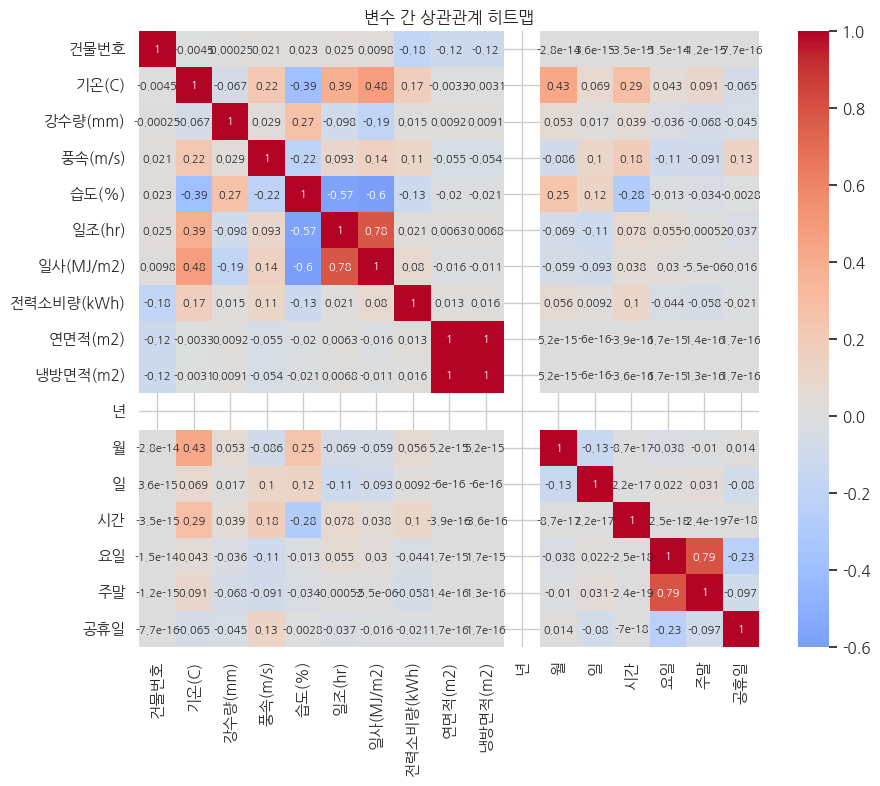

In [ ]:
# correlation_matrix = train_ft.corr()

# # 히트맵 그리기
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,annot_kws={'fontsize': 8})
# plt.title('변수 간 상관관계 히트맵')
# plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # NanumGothic 폰트의 경로로 변경해야 할 수도 있습니다.

# 폰트 이름 얻어오기
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()

# 폰트 설정하기
plt.rcParams["font.family"] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


In [ ]:
def get_histogram(data,index,values,func):
    pivot_table = data.pivot_table(index=index, values=values, aggfunc=func)
    pivot_table_s = pivot_table.reset_index().sort_values(by=values, ascending=False)

    # 그래프 table
    pivot_df = pivot_table_s.reset_index()

    # 히스토그램 그리기
    plt.figure(figsize=(10, 6))
    sns.barplot(data=pivot_df, x=index, y=values)
    plt.title(f'{index}별 {values} 히스토그램({func})')
    plt.xlabel(index)
    plt.ylabel(values)
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.tight_layout()
    plt.show()

In [ ]:
# #건물 유형당 연전력소비
# pivot_table = building.pivot_table(index='건물유형', values=['연전력소비(kWh)'], aggfunc='mean')
# pivot_table_s = pivot_table.reset_index().sort_values(by='연전력소비(kWh)', ascending=False)

# # 그래프 table
# pivot_df = pivot_table_s.reset_index()

# # 히스토그램 그리기
# plt.figure(figsize=(10, 6))
# sns.barplot(data=pivot_df, x='건물유형', y='연전력소비(kWh)')
# plt.title('건물 유형별 연전력소비 히스토그램')
# plt.xlabel('건물 유형')
# plt.ylabel('연전력소비(kWh)')
# plt.xticks(rotation=45)  # x축 레이블 회전
# plt.tight_layout()
# plt.show()


### 1) 건물 유형별 (12유형)

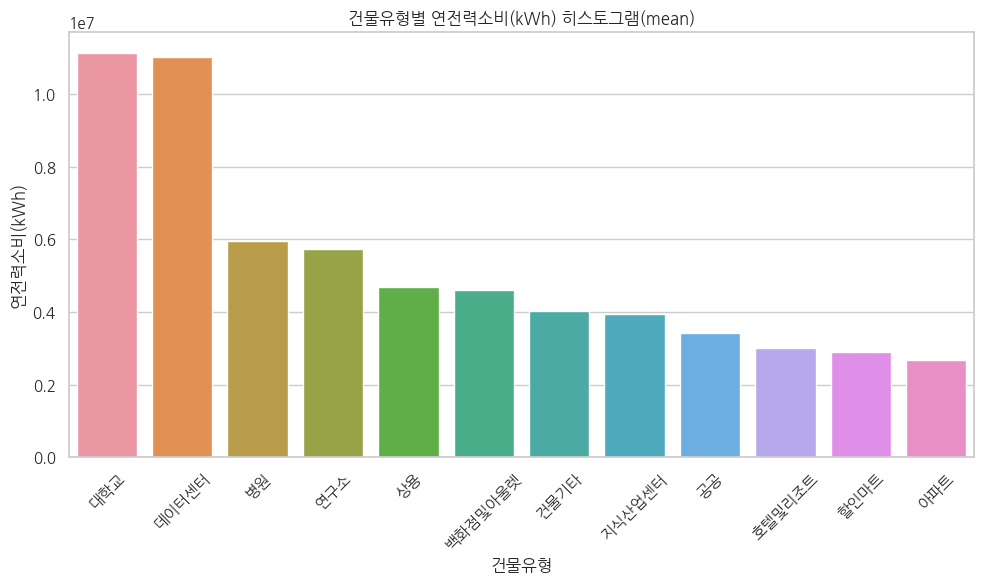

In [ ]:
get_histogram(building,'건물유형','연전력소비(kWh)','mean')

#대학교, 데이터센터 압도적으로 많이 씀 -> X공휴일, 24시간, 사람 많, 전자기기 많?

In [ ]:
def get_histogram_small(data,index,values,func):
    pivot_table = data.pivot_table(index=index, values=values, aggfunc=func)
    pivot_table_s = pivot_table.reset_index().sort_values(by=values, ascending=False)

    # 그래프 table
    pivot_df = pivot_table_s.reset_index()

    # 히스토그램 그리기
    plt.figure(figsize=(6, 4))
    sns.barplot(data=pivot_df, x=index, y=values)
    plt.title(f'{index}별 {values} 히스토그램({func})')
    plt.xlabel(index)
    plt.ylabel(values)
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.tight_layout()
    plt.show()

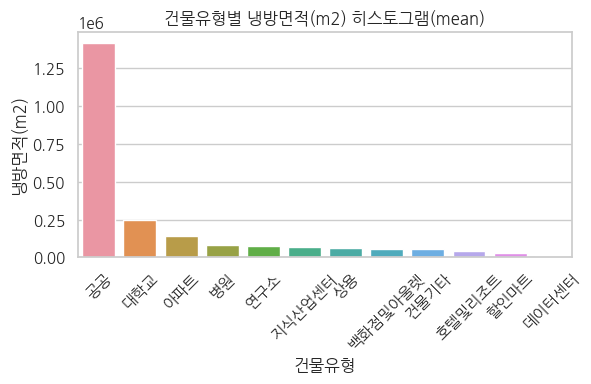

<Figure size 640x480 with 0 Axes>

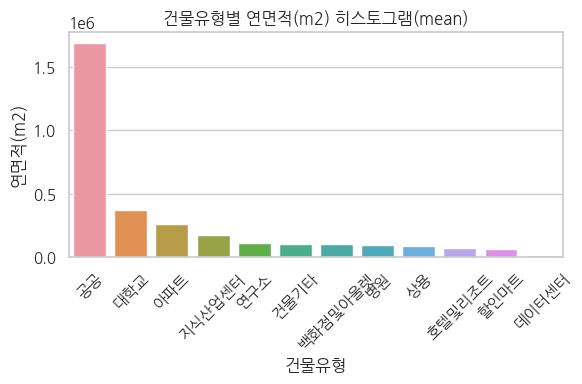

In [ ]:
get_histogram_small(building,'건물유형','냉방면적(m2)','mean')

plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(building,'건물유형','연면적(m2)','mean')


#연면적/냉방면적 이랑 열전력소비는 별 상관없어보임

In [ ]:
columns_to_convert = ['태양광용량(kW)', 'ESS저장용량(kWh)','PCS용량(kW)']
building[columns_to_convert] = building[columns_to_convert].astype(float)

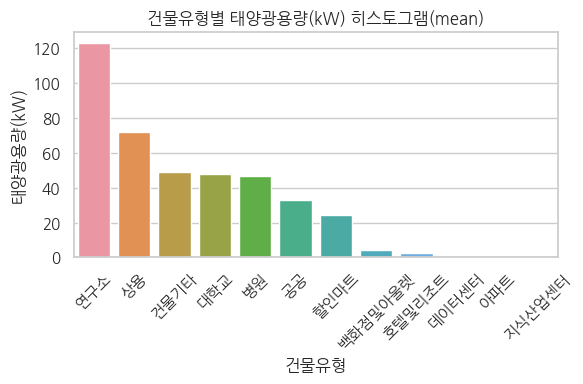

<Figure size 640x480 with 0 Axes>

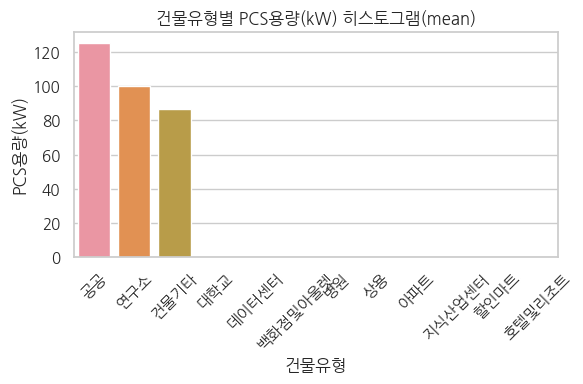

<Figure size 640x480 with 0 Axes>

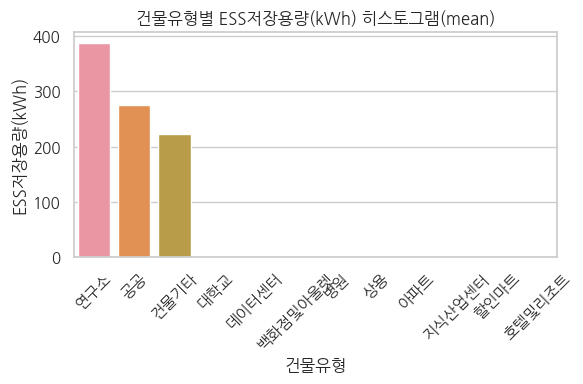

In [ ]:
get_histogram_small(building,'건물유형','태양광용량(kW)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(building,'건물유형','PCS용량(kW)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(building,'건물유형','ESS저장용량(kWh)','mean')

# 유형별 태양광용량 -> ?
# pcs, ess는 같이가는 columns, '공공, 연구소, 기타'에만 영향

In [ ]:
building.columns

Index(['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)',
       'PCS용량(kW)', '연전력소비(kWh)'],
      dtype='object')

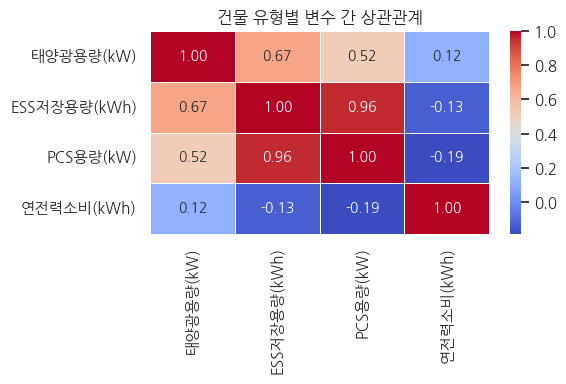

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 필요한 컬럼만 선택
columns = ['건물유형', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '연전력소비(kWh)']
subset_df = building[columns]

# 건물 유형별로 필요한 컬럼들의 평균값 계산
mean_values = subset_df.groupby('건물유형').mean()

# 상관관계 히트맵 그리기
corr_matrix = mean_values.corr()  # 상관관계 계산
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            annot_kws={'size': 10})  # 숫자 크기 조정을 위한 annot_kws 추가
plt.title('건물 유형별 변수 간 상관관계')
plt.tight_layout()
plt.show()



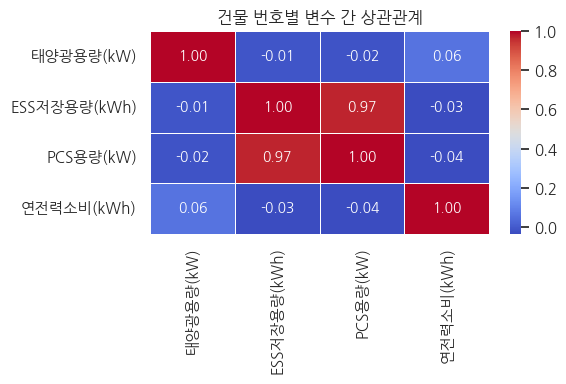

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 필요한 컬럼만 선택
columns = ['건물번호', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '연전력소비(kWh)']
subset_df = building[columns]

# 건물 유형별로 필요한 컬럼들의 평균값 계산
mean_values = subset_df.groupby('건물번호').mean()

# 상관관계 히트맵 그리기
corr_matrix = mean_values.corr()  # 상관관계 계산
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            annot_kws={'size': 10})  # 숫자 크기 조정을 위한 annot_kws 추가
plt.title('건물 번호별 변수 간 상관관계')
plt.tight_layout()
plt.show()


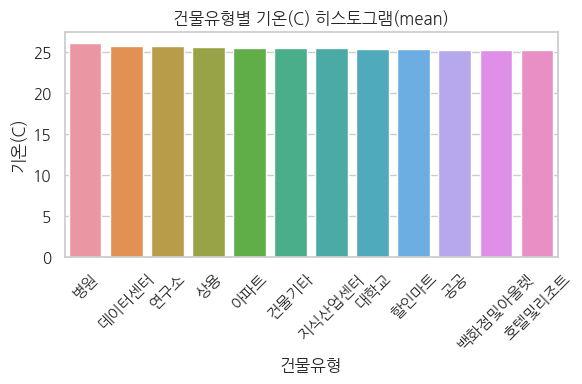

<Figure size 640x480 with 0 Axes>

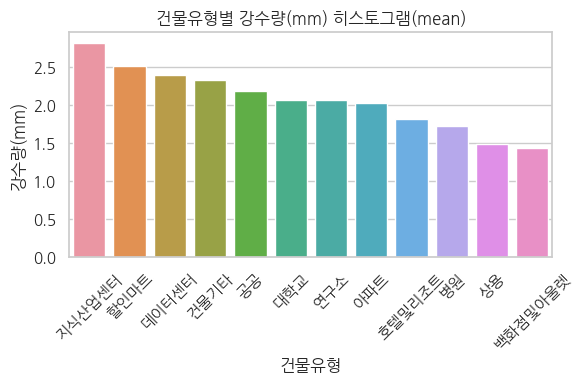

<Figure size 640x480 with 0 Axes>

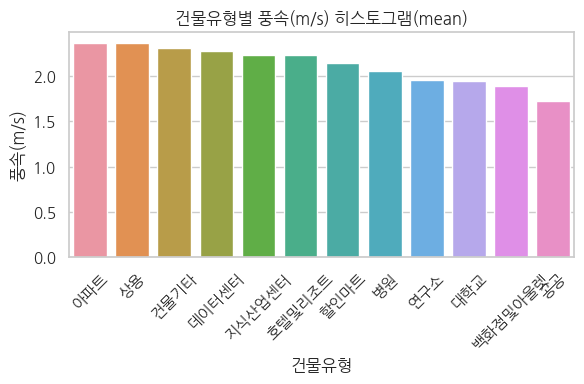

<Figure size 640x480 with 0 Axes>

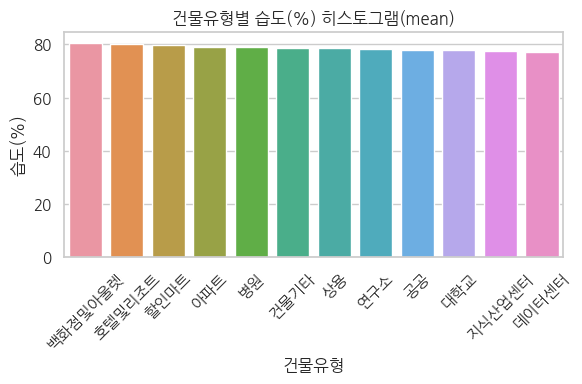

<Figure size 640x480 with 0 Axes>

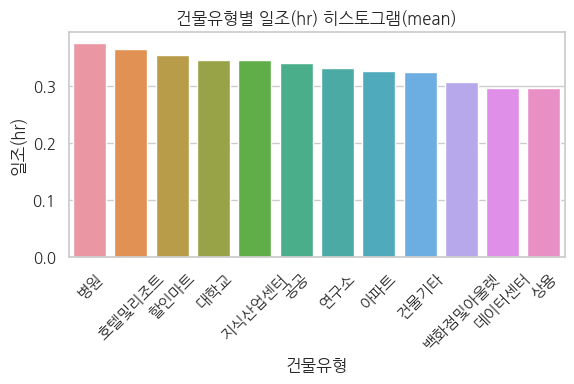

<Figure size 640x480 with 0 Axes>

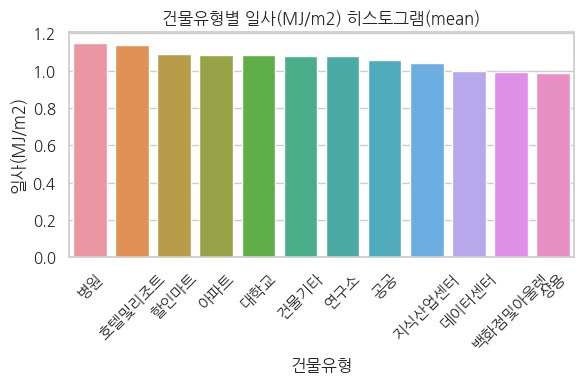

<Figure size 640x480 with 0 Axes>

In [ ]:
get_histogram_small(train_ft,'건물유형','기온(C)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물유형','강수량(mm)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물유형','풍속(m/s)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물유형','습도(%)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물유형','일조(hr)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물유형','일사(MJ/m2)','mean')
plt.tight_layout()  # 그래프 간격 조절

In [ ]:
train_ft.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '년', '월', '일', '시간', '요일',
       '주말', '공휴일'],
      dtype='object')

<ipython-input-209-95809311006f>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_values = subset_df.groupby('건물유형').mean()


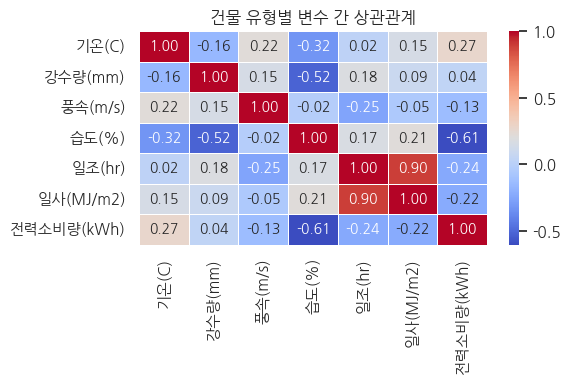

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 필요한 컬럼만 선택
columns = ['건물유형', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
subset_df = train_ft[columns]

# 건물 유형별로 필요한 컬럼들의 평균값 계산
mean_values = subset_df.groupby('건물유형').mean()

# 상관관계 히트맵 그리기
corr_matrix = mean_values.corr()  # 상관관계 계산
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            annot_kws={'size': 10})  # 숫자 크기 조정을 위한 annot_kws 추가
plt.title('건물 유형별 변수 간 상관관계')
plt.tight_layout()
plt.show()


<ipython-input-210-cb0d59dee483>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_values = subset_df.groupby('건물번호').mean()


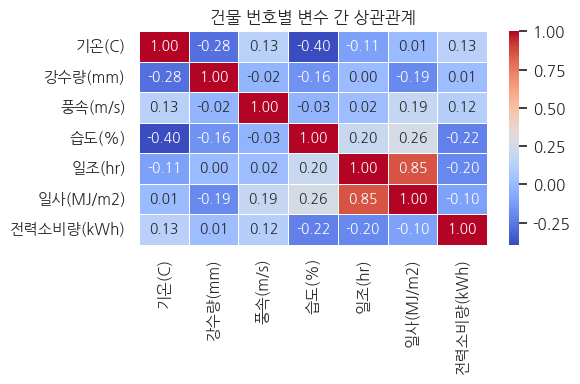

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 필요한 컬럼만 선택
columns = ['건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
subset_df = train_ft[columns]

# 건물 유형별로 필요한 컬럼들의 평균값 계산
mean_values = subset_df.groupby('건물번호').mean()

# 상관관계 히트맵 그리기
corr_matrix = mean_values.corr()  # 상관관계 계산
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            annot_kws={'size': 10})  # 숫자 크기 조정을 위한 annot_kws 추가
plt.title('건물 번호별 변수 간 상관관계')
plt.tight_layout()
plt.show()


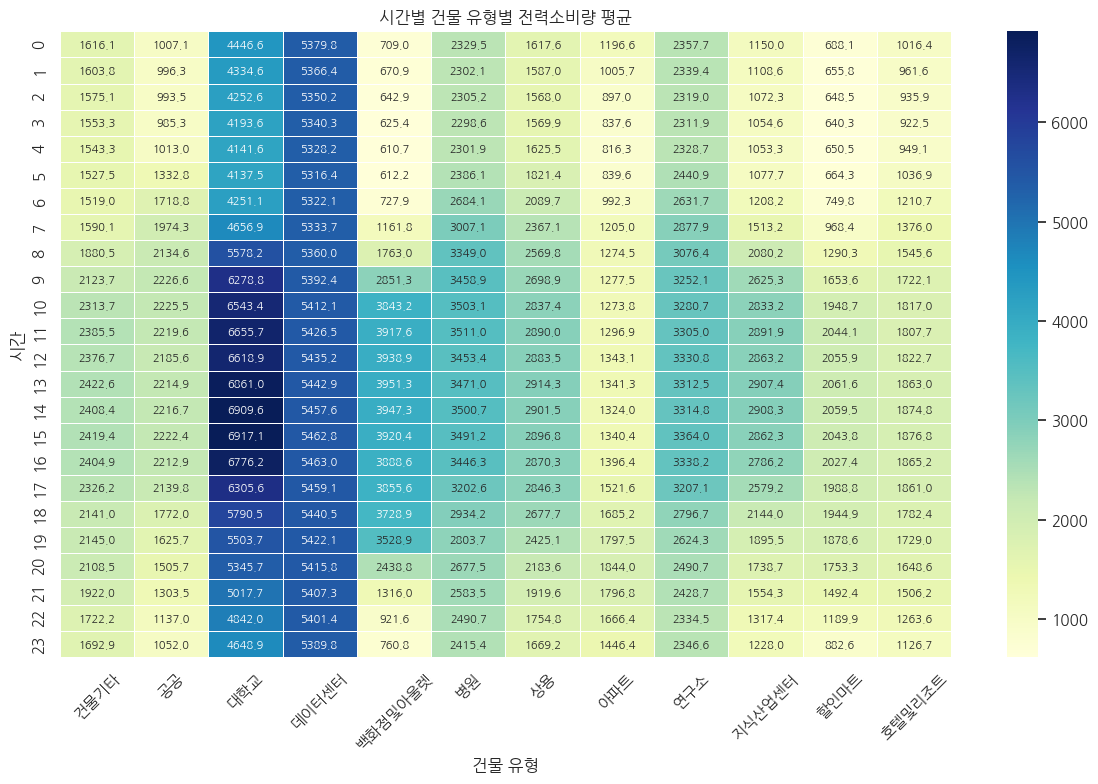

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 필요한 컬럼만 선택
columns = ['시간', '건물유형', '전력소비량(kWh)']
subset_df = train_ft[columns]

# 건물 유형과 시간에 따른 전력소비량의 합을 계산
power_pivot = subset_df.pivot_table(index='시간', columns='건물유형', values='전력소비량(kWh)', aggfunc='mean')

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(power_pivot, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5,
            annot_kws={'size': 8})  # 숫자 크기 조정을 위한 annot_kws 추가
plt.title('시간별 건물 유형별 전력소비량 평균')
plt.xlabel('건물 유형')
plt.ylabel('시간')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


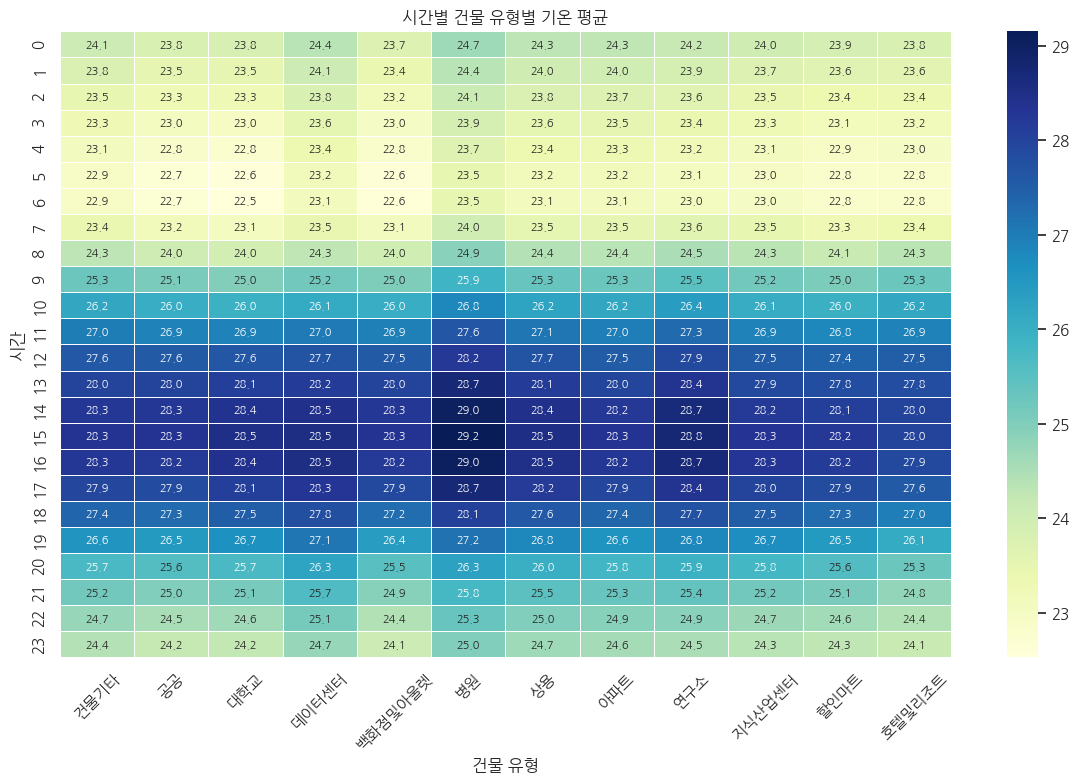

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 필요한 컬럼만 선택
columns = ['시간', '건물유형', '기온(C)']
subset_df = train_ft[columns]

# 건물 유형과 시간에 따른 전력소비량의 합을 계산
power_pivot = subset_df.pivot_table(index='시간', columns='건물유형', values='기온(C)', aggfunc='mean')

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(power_pivot, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5,
            annot_kws={'size': 8})  # 숫자 크기 조정을 위한 annot_kws 추가
plt.title('시간별 건물 유형별 기온 평균')
plt.xlabel('건물 유형')
plt.ylabel('시간')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

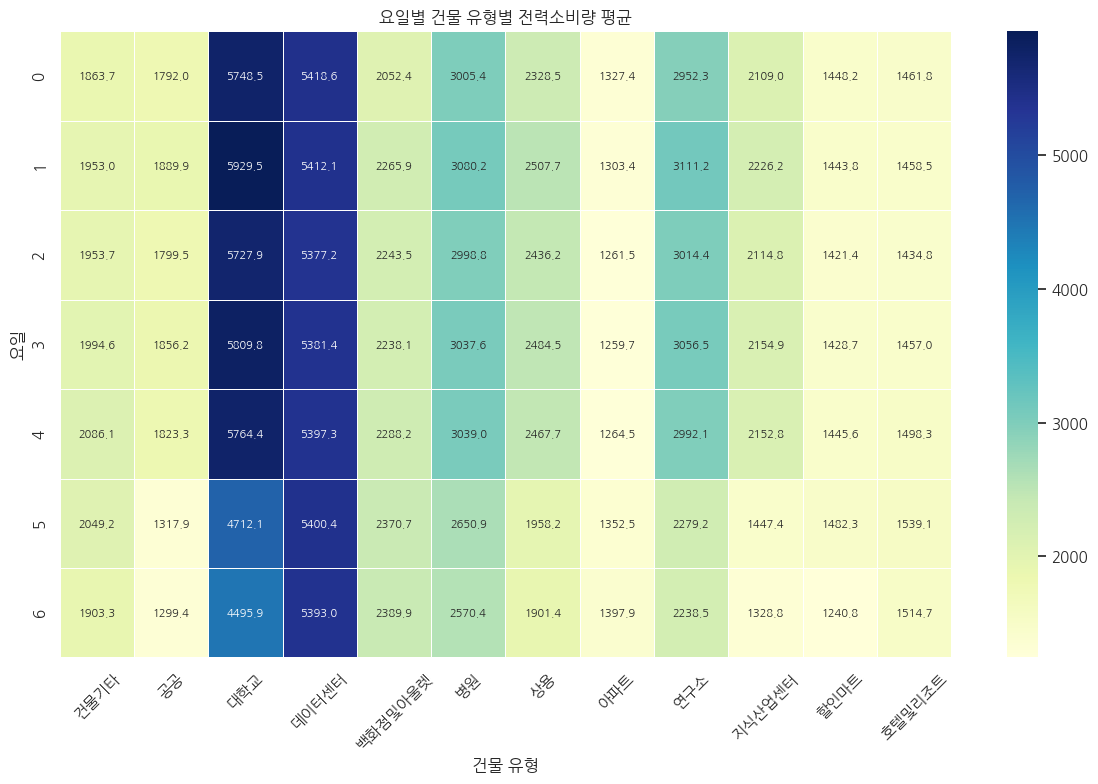

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 필요한 컬럼만 선택
columns = ['요일', '건물유형', '전력소비량(kWh)']
subset_df = train_ft[columns]

# 건물 유형과 시간에 따른 전력소비량의 합을 계산
power_pivot = subset_df.pivot_table(index='요일', columns='건물유형', values='전력소비량(kWh)', aggfunc='mean')

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(power_pivot, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5,
            annot_kws={'size': 8})  # 숫자 크기 조정을 위한 annot_kws 추가
plt.title('요일별 건물 유형별 전력소비량 평균')
plt.xlabel('건물 유형')
plt.ylabel('요일')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
train_ft.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '년', '월', '일', '시간', '요일',
       '주말', '공휴일'],
      dtype='object')

In [ ]:
building
building = building.replace('-',0)

building

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),연전력소비(kWh)
0,1,건물기타,110634.00,39570.00,0,0,0,5412163.68
1,2,건물기타,122233.47,99000.00,0,0,0,3421114.02
2,3,건물기타,171243.00,113950.00,40,0,0,2945920.14
3,4,건물기타,74312.98,34419.62,60,0,0,2030669.01
4,5,건물기타,205884.00,150000.00,0,2557,1000,5587661.16
...,...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,0,0,0,5728397.70
96,97,호텔및리조트,55144.67,25880.00,0,0,0,2521281.24
97,98,호텔및리조트,53578.62,17373.75,0,0,0,2317674.42
98,99,호텔및리조트,53499.00,40636.00,0,0,0,2366164.98


### 2) 건물 번호별

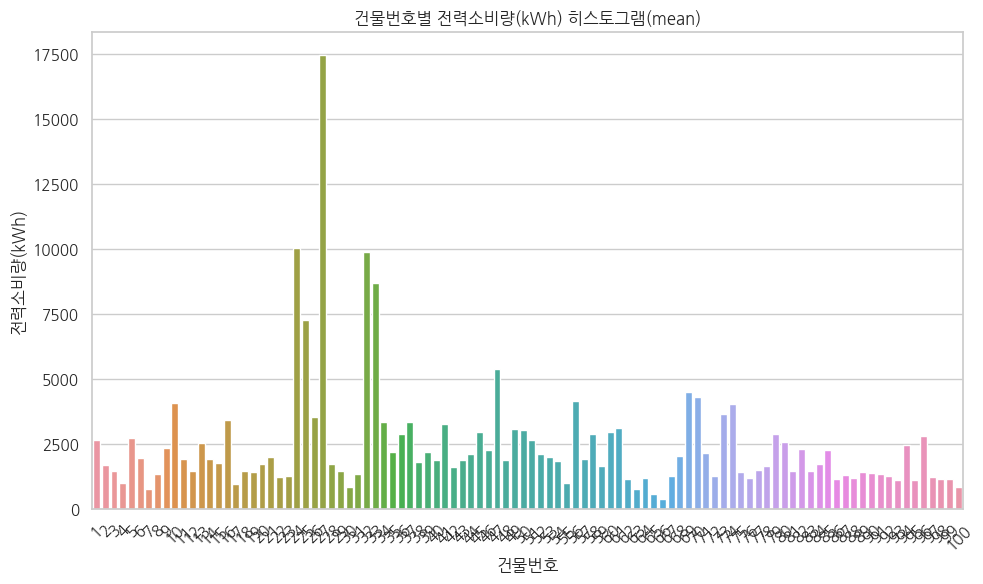

In [ ]:
get_histogram(train_ft,'건물번호','전력소비량(kWh)','mean')


In [ ]:
cols = ['건물번호','전력소비량(kWh)']
train_ft[cols].sort_values(by='전력소비량(kWh)',ascending=False)

,건물번호,전력소비량(kWh)
53895,27,25488.40
53894,27,25415.60
53896,27,25354.00
54590,27,25342.80
54589,27,25328.80
...,...,...
59170,30,171.90
59171,30,164.40
59172,30,143.70
193121,95,0.36


In [ ]:
train_ft = train_ft.replace('-',0)
columns_to_convert = ['태양광용량(kW)', 'ESS저장용량(kWh)','PCS용량(kW)']
train_ft[columns_to_convert] = train_ft[columns_to_convert].astype(float)

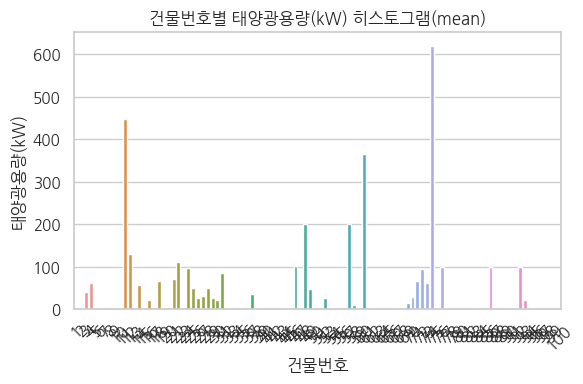

<Figure size 640x480 with 0 Axes>

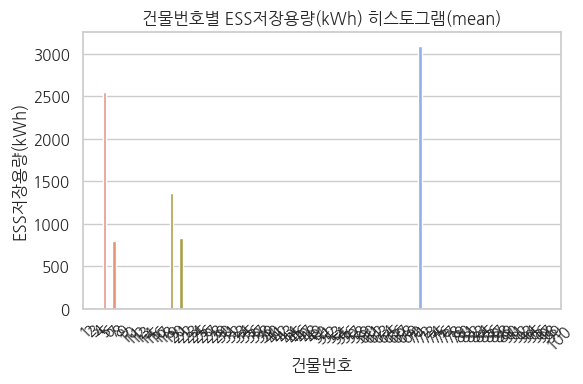

<Figure size 640x480 with 0 Axes>

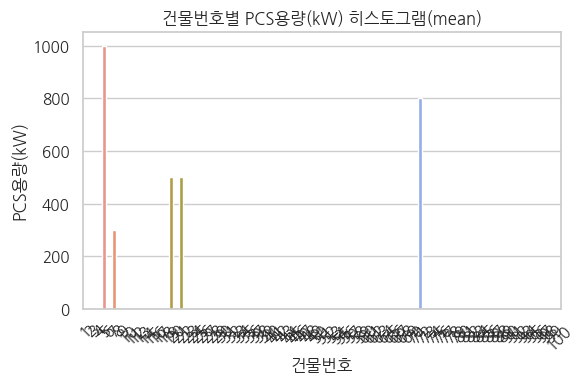

<Figure size 640x480 with 0 Axes>

In [ ]:
get_histogram_small(train_ft,'건물번호','태양광용량(kW)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물번호','ESS저장용량(kWh)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물번호','PCS용량(kW)','mean')
plt.tight_layout()  # 그래프 간격 조절



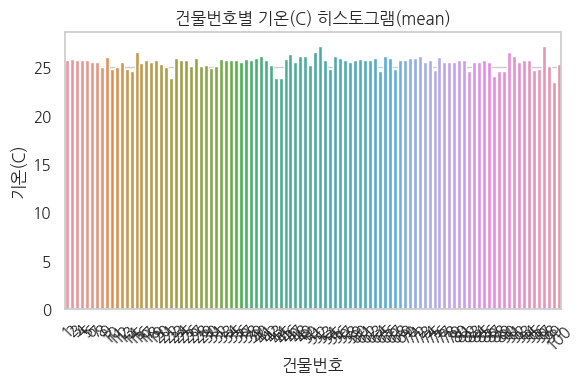

<Figure size 640x480 with 0 Axes>

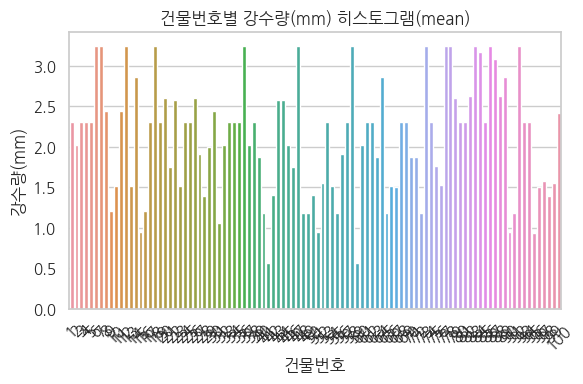

<Figure size 640x480 with 0 Axes>

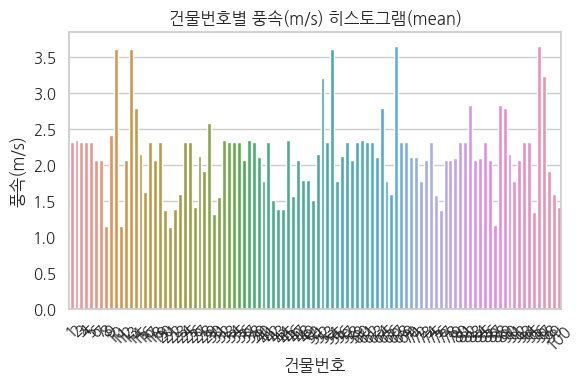

<Figure size 640x480 with 0 Axes>

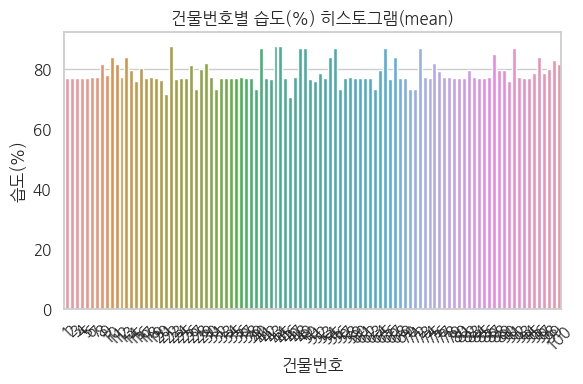

<Figure size 640x480 with 0 Axes>

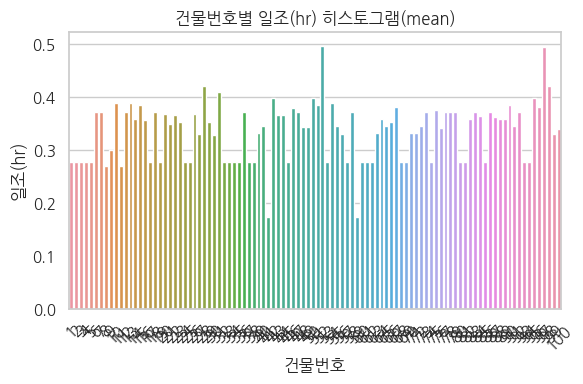

<Figure size 640x480 with 0 Axes>

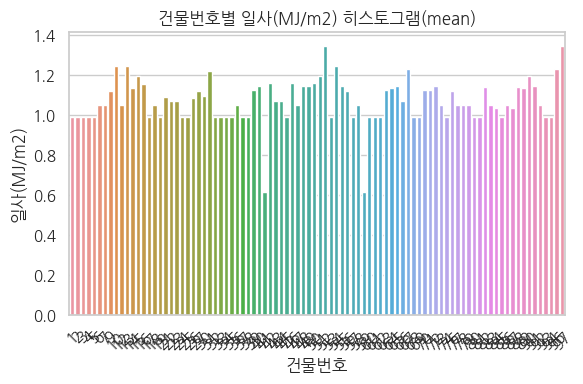

<Figure size 640x480 with 0 Axes>

In [ ]:
get_histogram_small(train_ft,'건물번호','기온(C)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물번호','강수량(mm)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물번호','풍속(m/s)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물번호','습도(%)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물번호','일조(hr)','mean')
plt.tight_layout()  # 그래프 간격 조절

get_histogram_small(train_ft,'건물번호','일사(MJ/m2)','mean')
plt.tight_layout()  # 그래프 간격 조절


In [ ]:
train_ft.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '년', '월', '일', '시간', '요일',
       '주말', '공휴일'],
      dtype='object')

In [ ]:
power_usage_by_building_time = train_ft.groupby(['건물번호', '시간'])['전력소비량(kWh)'].sum().reset_index()
power_usage_by_building_time

,건물번호,시간,전력소비량(kWh)
0,1,0,145037.04
1,1,1,137922.72
2,1,2,128092.56
3,1,3,122176.08
4,1,4,123022.32
...,...,...,...
2395,100,19,85889.28
2396,100,20,78890.64
2397,100,21,70552.80
2398,100,22,61463.52


In [ ]:
# # 시간대별 건물 번호별 전력 사용량 합 데이터를 pivot 형태로 변환
# power_pivot = power_usage_by_building_time.pivot(index='건물번호', columns='시간', values='전력소비량(kWh)').fillna(0)

# # 히트맵으로 시각화
# plt.figure(figsize=(10, 6))
# sns.heatmap(power_pivot, cmap='YlGnBu', linewidths=0.5)
# plt.xlabel('시간대')
# plt.ylabel('건물 번호')
# plt.title('시간대별 건물 번호별 전력 사용량 합')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


### 개별 건물 feature vs 건물 유형 feature
- 건물별 차이가 유의미한 것 : -> 유형별 모델링하면 성능 더 좋을 것
- 유형별 차이가 유의미한 것 : 냉방면적, 전력 소비량 -> 관련 feature 추가하고 개별건물 모델링하면 성능 더 좋음(???)

# Feature 추가

###  일자 관련 피처
- 년, 월, 일, 시간, 요일, 주말, 공휴일

In [ ]:
# co = ['년','월','일','시간','요일']
# train = train.drop(columns=co,axis=1)

In [ ]:
train_ft['일시'] = pd.to_datetime(train_ft['일시'])

# 년, 월, 일, 시간 추출하여 새로운 칼럼 추가
# train_ft['년'] = train_ft['일시'].dt.year
train_ft['월'] = train_ft['일시'].dt.month
train_ft['일'] = train_ft['일시'].dt.day
train_ft['시간'] = train_ft['일시'].dt.hour

# 요일 추출하여 새로운 칼럼 추가 (월요일: 0, 일요일: 6)
train_ft['요일'] = train_ft['일시'].dt.weekday

In [ ]:
# '주말' 여부 추출하여 칼럼 추가
train_ft['주말'] = 0
train_ft.loc[(train_ft['요일'] == 5) | (train_ft['요일'] == 6), '주말'] = 1

In [ ]:
# 공휴일 여부 추가
!pip install holidays

In [ ]:
import holidays

# 한국의 공휴일 목록 불러오기
kr_holidays = holidays.Korea()

# '공휴일' 칼럼 추가
train_ft['공휴일'] = train_ft['일시'].apply(lambda x: 1 if x in kr_holidays else 0)

In [ ]:
#냉방시간대 추가 (8시~18시)

# train_ft['냉방시간'] = np.where((train_ft['시간'] >= 8) & (train_ft['시간'] <= 18), 1, 0)


In [ ]:
train_ft

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,ESS저장용량(kWh),PCS용량(kW),년,월,일,시간,요일,주말,공휴일,냉방시간
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,...,0.0,0.0,2022,6,1,0,2,0,0,0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,...,0.0,0.0,2022,6,1,1,2,0,0,0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,...,0.0,0.0,2022,6,1,2,2,0,0,0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,...,0.0,0.0,2022,6,1,3,2,0,0,0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,...,0.0,0.0,2022,6,1,4,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,NaN,0.9,86.0,0.5,NaN,881.04,...,0.0,0.0,2022,8,24,19,2,0,0,0
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,NaN,1.3,86.0,0.0,NaN,798.96,...,0.0,0.0,2022,8,24,20,2,0,0,0
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,NaN,1.0,92.0,NaN,NaN,825.12,...,0.0,0.0,2022,8,24,21,2,0,0,0
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,NaN,0.3,94.0,NaN,NaN,640.08,...,0.0,0.0,2022,8,24,22,2,0,0,0


### 온도/습도/냉방 관련 피처
- Base : 열지수, 한파지수, 불쾌지수, 체감온도, 열집중지수 (계산 가능)

In [ ]:
train_ft.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'],
      dtype='object')

In [ ]:
# 필요한 패키지 임포트
import math

# 변수 정의
# relative_humidity = 60  # 상대습도 (%)
# wind_speed = 5  # 바람 속도 (m/s)
# solar_radiation = 600  # 태양광량 (W/m^2)
# occupancy_density = 5  # 인원 밀도 (명/m^2)
# cooling_system_mode = 'active'  # 냉방시스템 운영 모드 ('active' 또는 'passive')
# energy_consumption = 1000  # 에너지 소비량 (kWh)
# energy_cost = 0.15  # 에너지 비용 ($/kWh)

# 열지수 (Heat Index) 계산식 ***
train_ft['heat_index'] = -8.78469475556 + 1.61139411 * train_ft['기온(C)'] + 2.33854883889 * train_ft['습도(%)'] - 0.14611605 * train_ft['기온(C)'] * train_ft['습도(%)'] - 0.012308094 * (train_ft['기온(C)'] ** 2) - 0.016424828 * (train_ft['습도(%)'] ** 2) + 0.002211732 * (train_ft['기온(C)'] ** 2) * train_ft['습도(%)'] + 0.00072546 * train_ft['기온(C)'] * (train_ft['습도(%)'] ** 2) - 0.000003582 * (train_ft['기온(C)'] ** 2) * (train_ft['습도(%)'] ** 2)

# 한파지수 (Wind Chill) 계산식 ***
train_ft['wind_chill'] = 13.12 + 0.6215 * train_ft['기온(C)'] - 11.37 * (train_ft['풍속(m/s)'] ** 0.16) + 0.3965 * train_ft['기온(C)'] * (train_ft['풍속(m/s)'] ** 0.16)

# 불쾌지수 (Discomfort Index) 계산식 ***
train_ft['discomfort_index'] = 0.81 * train_ft['기온(C)'] + 0.01 * train_ft['습도(%)'] * (0.99 * train_ft['기온(C)'] - 14.3) + 46.3

# 체감온도 (Apparent Temperature) 계산식 ***
train_ft['apparent_temperature'] = 37.9 + 0.33 * train_ft['기온(C)'] - 37.9 * (train_ft['풍속(m/s)'] ** 0.16)

# 적심온도 (Wet Bulb Globe Temperature, WBGT) 계산식
# wbgt = 0.7 * train_ft['기온(C)'] + 0.2 * wet_bulb_temperature + 0.1 * globe_temperature

# 열집중지수 (Apparent Temperature) 계산식 (예시 코드) ***
train_ft['heat_stress_index'] = -42.379 + 2.04901523 * train_ft['기온(C)'] + 10.14333127 * train_ft['습도(%)'] - 0.22475541 * train_ft['기온(C)'] * train_ft['습도(%)'] - 6.83783 * (10 ** -3) * (train_ft['기온(C)'] ** 2) - 5.481717 * (10 ** -2) * (train_ft['습도(%)'] ** 2) + 1.22874 * (10 ** -3) * (train_ft['기온(C)'] ** 2) * train_ft['습도(%)'] + 8.5282 * (10 ** -4) * train_ft['기온(C)'] * (train_ft['습도(%)'] ** 2) - 1.99 * (10 ** -6) * (train_ft['기온(C)'] ** 2) * (train_ft['습도(%)'] ** 2)

# 상대습도 (Relative Humidity) 계산식 (예시 코드)
# relative_humidity = (actual_vapor_pressure / saturated_vapor_pressure) * 100

# 태양광량 (Solar Radiation) 계산식 (예시 코드)
# solar_radiation = solar_constant * solar_constant_factor * math.cos(math.radians(solar_elevation_angle))

# 인원 밀도 (Occupancy Density) 계산식 (예시 코드)
# occupancy_density = number_of_occupants / room_area

# 냉방시스템 운영 모드 (Cooling System Mode)에 따른 에너지 소비 계산 (예시 코드)
# if cooling_system_mode == 'active':
#     energy_consumption += active_cooling_energy
# elif cooling_system_mode == 'passive':
#     energy_consumption += passive_cooling_energy

# 에너지 비용 (Energy Cost) 계산
# total_energy_cost = energy_consumption * energy_cost

# 계산


In [ ]:
train_ft

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,시간,요일,주말,공휴일,냉방시간,heat_index,wind_chill,discomfort_index,apparent_temperature,heat_stress_index
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,...,0,2,0,0,0,25.782731,20.751584,63.09388,6.771551,191.731473
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,...,1,2,0,0,0,26.192917,20.008954,62.46400,5.357610,203.375752
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,...,2,2,0,0,0,26.384909,19.476910,62.08735,3.300752,204.801358
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,...,3,2,0,0,0,27.193455,18.487958,60.89884,3.414711,218.333640
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,...,4,2,0,0,0,25.916561,19.751534,62.88788,-0.715339,195.644343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,NaN,0.9,86.0,0.5,NaN,881.04,...,19,2,0,0,0,22.537665,25.302757,72.38034,8.256551,215.940120
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,NaN,1.3,86.0,0.0,NaN,798.96,...,20,2,0,0,0,21.627667,24.446518,71.21736,5.767158,220.941779
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,NaN,1.0,92.0,NaN,NaN,825.12,...,21,2,0,0,0,19.101477,23.433400,69.79704,7.029000,224.340441
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,NaN,0.3,94.0,NaN,NaN,640.08,...,22,2,0,0,0,18.228141,23.661275,69.41060,13.570746,224.503953


In [ ]:
train_ft.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '월', '일', '시간', '요일', '주말',
       'heat_index', 'wind_chill', 'discomfort_index', 'apparent_temperature',
       'heat_stress_index', '공휴일'],
      dtype='object')

# 검증

- 건물유형별 예측 보다는 건물별 예측이 더 나은듯?
-

- 특정 건물번호

In [ ]:
mask = train_ft['건물번호'] == 1
train_ft_1 = train_ft[mask]


In [ ]:
train_ft_1

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,일,시간,요일,주말,heat_index,wind_chill,discomfort_index,apparent_temperature,heat_stress_index,공휴일
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,...,1,0,2,0,25.782731,20.751584,63.09388,6.771551,191.731473,0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,...,1,1,2,0,26.192917,20.008954,62.46400,5.357610,203.375752,0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,...,1,2,2,0,26.384909,19.476910,62.08735,3.300752,204.801358,0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,...,1,3,2,0,27.193455,18.487958,60.89884,3.414711,218.333640,0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,...,1,4,2,0,25.916561,19.751534,62.88788,-0.715339,195.644343,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,1_20220824 19,1,2022-08-24 19:00:00,25.5,NaN,2.9,63.0,0.1,0.19,2517.12,...,24,19,2,0,26.489644,27.475127,73.85035,1.376053,197.329411,0
2036,1_20220824 20,1,2022-08-24 20:00:00,25.0,NaN,2.6,66.0,0.0,0.01,2208.96,...,24,20,2,0,25.998333,26.959240,73.44700,1.989402,202.542430,0
2037,1_20220824 21,1,2022-08-24 21:00:00,24.6,NaN,1.3,67.0,NaN,NaN,1806.24,...,24,21,2,0,25.588129,26.723515,72.96218,6.493158,205.566434,0
2038,1_20220824 22,1,2022-08-24 22:00:00,24.1,NaN,2.1,70.0,NaN,NaN,1387.20,...,24,22,2,0,25.017259,26.055113,72.51230,3.175959,210.300015,0


- 특정 건물유형

In [ ]:
mask = train_ft['건물유형'] == '건물기타'
train_ft_ty1 = train_ft[mask]

In [ ]:
train_ft_ty1

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,일,시간,요일,주말,heat_index,wind_chill,discomfort_index,apparent_temperature,heat_stress_index,공휴일
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,...,1,0,2,0,25.782731,20.751584,63.09388,6.771551,191.731473,0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,...,1,1,2,0,26.192917,20.008954,62.46400,5.357610,203.375752,0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,...,1,2,2,0,26.384909,19.476910,62.08735,3.300752,204.801358,0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,...,1,3,2,0,27.193455,18.487958,60.89884,3.414711,218.333640,0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,...,1,4,2,0,25.916561,19.751534,62.88788,-0.715339,195.644343,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30595,15_20220824 19,15,2022-08-24 19:00:00,21.7,NaN,1.6,91.0,0.0,0.16,1819.44,...,24,19,2,0,19.815984,23.624578,70.41353,4.200996,222.285050,0
30596,15_20220824 20,15,2022-08-24 20:00:00,21.8,NaN,1.7,92.0,0.0,0.00,1918.17,...,24,20,2,0,19.722369,23.700826,70.65744,3.835728,220.561104,0
30597,15_20220824 21,15,2022-08-24 21:00:00,21.4,NaN,1.1,92.0,NaN,NaN,1999.53,...,24,21,2,0,19.219221,23.490869,69.96912,6.479610,223.580999,0
30598,15_20220824 22,15,2022-08-24 22:00:00,21.4,NaN,0.3,92.0,NaN,NaN,2043.63,...,24,22,2,0,19.219221,24.040685,69.96912,13.702746,223.580999,0


In [ ]:
train_ft_1.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '월', '일', '시간', '요일', '주말',
       'heat_index', 'wind_chill', 'discomfort_index', 'apparent_temperature',
       'heat_stress_index', '공휴일'],
      dtype='object')

In [ ]:
columns = ['건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)',]

train_x = train_ft_1[columns]
train_y = train_ft_1['전력소비량(kWh)']

In [ ]:
train_x

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),연면적(m2),냉방면적(m2),월,일,시간,요일,주말,heat_index,wind_chill,discomfort_index,apparent_temperature,heat_stress_index,공휴일
0,1,18.6,NaN,0.9,42.0,110634.0,39570.0,6,1,0,2,0,25.782731,20.751584,63.09388,6.771551,191.731473,0
1,1,18.0,NaN,1.1,45.0,110634.0,39570.0,6,1,1,2,0,26.192917,20.008954,62.46400,5.357610,203.375752,0
2,1,17.7,NaN,1.5,45.0,110634.0,39570.0,6,1,2,2,0,26.384909,19.476910,62.08735,3.300752,204.801358,0
3,1,16.7,NaN,1.4,48.0,110634.0,39570.0,6,1,3,2,0,27.193455,18.487958,60.89884,3.414711,218.333640,0
4,1,18.4,NaN,2.8,43.0,110634.0,39570.0,6,1,4,2,0,25.916561,19.751534,62.88788,-0.715339,195.644343,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,1,25.5,NaN,2.9,63.0,110634.0,39570.0,8,24,19,2,0,26.489644,27.475127,73.85035,1.376053,197.329411,0
2036,1,25.0,NaN,2.6,66.0,110634.0,39570.0,8,24,20,2,0,25.998333,26.959240,73.44700,1.989402,202.542430,0
2037,1,24.6,NaN,1.3,67.0,110634.0,39570.0,8,24,21,2,0,25.588129,26.723515,72.96218,6.493158,205.566434,0
2038,1,24.1,NaN,2.1,70.0,110634.0,39570.0,8,24,22,2,0,25.017259,26.055113,72.51230,3.175959,210.300015,0


In [ ]:
# train_x = train_ft_ty1.drop(columns=['건물유형','일시', '일조(hr)', '일사(MJ/m2)','태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)','연전력소비(kWh)','전력소비량(kWh)'])
# train_y = train_ft_ty1['전력소비량(kWh)']

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [1]:
def smape(
    X_val, y_val, estimator, labels,
    X_train, y_train, weight_val=None, weight_train=None,
    *args, **kwargs
):
    def _smape(true, pred):
        v = 2 * abs(pred - true) / (abs(pred) + abs(true))
        output = np.mean(v) * 100
        return output

    y_pred = estimator.predict(X_val)
    val_loss = _smape(y_val, y_pred)
    y_pred = estimator.predict(X_train)
    train_loss = _smape(y_train, y_pred)

    return val_loss, {
        "val_loss": val_loss,
        "train_lo

SyntaxError: ignored

In [ ]:
cv = KFold(n_splits=5,shuffle=True, random_state=SEED)

In [ ]:
scores = []
models = []
for tri, vai in cv.split(train_x,train_y):
    x_train = train_x.iloc[tri]
    y_train = train_y.iloc[tri]

    x_valid = train_x.iloc[vai]
    y_valid = train_y.iloc[vai]

    model = LGBMRegressor(random_state=SEED)
    model.fit(x_train, y_train)
    pred = model.predict(x_valid)
    score = smape(y_valid, pred)
    scores.append(score)
    models.append(model)

np.mean(scores)

#건물별 : train_ft_1 4.907195473271963
#유형별 : train_ft_ty1 8.204513786291127


5.081581713229599

In [ ]:
scores = []
models = []
for tri, vai in cv.split(train_x,train_y):
    x_train = train_x.iloc[tri]
    y_train = train_y.iloc[tri]

    x_valid = train_x.iloc[vai]
    y_valid = train_y.iloc[vai]

    model = XGBRegressor(random_state=SEED, objective = 'reg:squarederror')
    model.fit(x_train, y_train)
    pred = model.predict(x_valid)
    score = smape(y_valid, pred)
    scores.append(score)
    models.append(model)

np.mean(scores)

#건물별 : train_ft_1 4.961435114609265
#유형별 : train_ft_ty1 7.308939281494287


5.089972461667029

# -----------------참고------------------